In [1]:
# Importing the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

In [2]:
# Reading the Data for Inspection
raw_data = pd.read_csv('../data/raw/car_insurance_claim.csv')

In [3]:
raw_data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,...,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,...,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,...,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


In [4]:
pd.set_option('display.max_columns', None)
raw_data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


In [5]:
# Cleaning the Data
data_df = raw_data.copy() # Creating a copy to work with

In [6]:
# Update column names to make them more descriptive and easier to work with.
col_names = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}

# Update column names
data_df = data_df.rename(columns=col_names)
data_df.head()

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


In [7]:
# Read the general info of each feature
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  commute_dist               10302 non-null  int

In [8]:
# Check for duplicated rows
print(data_df.duplicated().sum())

1


In [9]:
# Since there is only a single duplicated row, I'll drop it.
data_df.drop_duplicates(inplace=True)

In [10]:
print(data_df.duplicated().sum())

0


In [11]:
# Investigating some features that have extra characters in their values.
for col in ['single_parent', 'married', 'gender', 'highest_education', 'occupation', 'type_of_use',
            'vehicle_type', 'red_vehicle', 'licence_revoked', 'address_type']:
    print(f"\n--- {col} ---")
    print(data_df[col].value_counts(dropna=False))


--- single_parent ---
single_parent
No     8958
Yes    1343
Name: count, dtype: int64

--- married ---
married
Yes     6187
z_No    4114
Name: count, dtype: int64

--- gender ---
gender
z_F    5545
M      4756
Name: count, dtype: int64

--- highest_education ---
highest_education
z_High School    2952
Bachelors        2822
Masters          2078
<High School     1515
PhD               934
Name: count, dtype: int64

--- occupation ---
occupation
z_Blue Collar    2288
Clerical         1590
Professional     1407
Manager          1257
Lawyer           1031
Student           899
Home Maker        843
NaN               665
Doctor            321
Name: count, dtype: int64

--- type_of_use ---
type_of_use
Private       6512
Commercial    3789
Name: count, dtype: int64

--- vehicle_type ---
vehicle_type
z_SUV          2883
Minivan        2693
Pickup         1772
Sports Car     1179
Van             921
Panel Truck     853
Name: count, dtype: int64

--- red_vehicle ---
red_vehicle
no     7326
yes 

In [12]:
# Cleaning the features with values that start with 'z_'
cols_to_clean = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']

data_df[cols_to_clean] = data_df[cols_to_clean].apply(lambda x: x.str.replace(r'^z_', '', regex=True))

In [13]:
for col in ['single_parent', 'married', 'gender', 'highest_education', 'occupation', 'type_of_use',
            'vehicle_type', 'red_vehicle', 'licence_revoked', 'address_type']:
    print(f"\n--- {col} ---")
    print(data_df[col].value_counts(dropna=False))


--- single_parent ---
single_parent
No     8958
Yes    1343
Name: count, dtype: int64

--- married ---
married
Yes    6187
No     4114
Name: count, dtype: int64

--- gender ---
gender
F    5545
M    4756
Name: count, dtype: int64

--- highest_education ---
highest_education
High School     2952
Bachelors       2822
Masters         2078
<High School    1515
PhD              934
Name: count, dtype: int64

--- occupation ---
occupation
Blue Collar     2288
Clerical        1590
Professional    1407
Manager         1257
Lawyer          1031
Student          899
Home Maker       843
NaN              665
Doctor           321
Name: count, dtype: int64

--- type_of_use ---
type_of_use
Private       6512
Commercial    3789
Name: count, dtype: int64

--- vehicle_type ---
vehicle_type
SUV            2883
Minivan        2693
Pickup         1772
Sports Car     1179
Van             921
Panel Truck     853
Name: count, dtype: int64

--- red_vehicle ---
red_vehicle
no     7326
yes    2975
Name: count,

In [14]:
# Removing the $ sign in front of the currency values.
currency_cols = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']

data_df[currency_cols] = (data_df[currency_cols]
                            .apply(lambda x: x.str.replace(r'^\$', '', regex=True)) # removing leaing $
                            .apply(lambda x: x.str.replace(',', ''))                # removing commas
                            .astype('Int64')                                        # convering to nullable integer type
                         )

In [15]:
for col in ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']:
    print(f"\n--- {col} ---")
    print(data_df[col].value_counts(dropna=False))


--- income ---
income
0         797
<NA>      570
61790       5
26840       4
64916       4
         ... 
43112       1
164669      1
107204      1
53235       1
16039       1
Name: count, Length: 8152, dtype: Int64

--- value_of_home ---
value_of_home
0         2908
<NA>       575
176219       3
225043       3
99103        3
          ... 
386273       1
332591       1
170611       1
197017       1
334777       1
Name: count, Length: 6335, dtype: Int64

--- vehicle_value ---
vehicle_value
1500     207
6200      47
6000      42
5800      39
5600      38
        ... 
13560      1
41790      1
27840      1
36980      1
35280      1
Name: count, Length: 2985, dtype: Int64

--- 5_year_total_claims_value ---
5_year_total_claims_value
0        6291
1391        4
4188        4
1310        4
4448        4
         ... 
35324       1
5208        1
7332        1
3436        1
9550        1
Name: count, Length: 3545, dtype: Int64

--- new_claim_value ---
new_claim_value
0       7555
4363       4

In [16]:
# Dropping the unnecessary features ['ID', 'date_of_birth']
data_df = data_df.drop(['ID', 'date_of_birth'], axis=1)
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [17]:
# Save cleaned dataset to the processed data folder
data_df.to_csv('../data/processed/car_insurance_claim_processed.csv', index=False)

In [18]:
data_df = pd.read_csv('../data/processed/car_insurance_claim_processed.csv')
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349.0,No,0.0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449.0,No,257252.0,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881.0,No,0.0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039.0,No,124191.0,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,NaN,No,306251.0,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [19]:
pd.set_option('display.max_columns', None)
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349.0,No,0.0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449.0,No,257252.0,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881.0,No,0.0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039.0,No,124191.0,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,NaN,No,306251.0,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [20]:
data_df['is_claim'].value_counts(dropna=False)

is_claim
0    7555
1    2746
Name: count, dtype: int64

In [21]:
# Making sure 'new_claim_value' and 'is_claim' features are int.
data_df['new_claim_value'] = (data_df['new_claim_value'].replace(',', '', regex=True).astype(float).astype(int))
data_df['is_claim'] = data_df['is_claim'].replace(',', '', regex=True).astype(float).astype(int)

In [22]:
# Checking if there are no non-zero values for 'new_claim_value' where 'is_claim' == 1.
mask = (data_df['new_claim_value'] > 0) & (data_df['is_claim'] == 0)
data_df[mask]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


<Axes: xlabel='new_claim_value', ylabel='Count'>

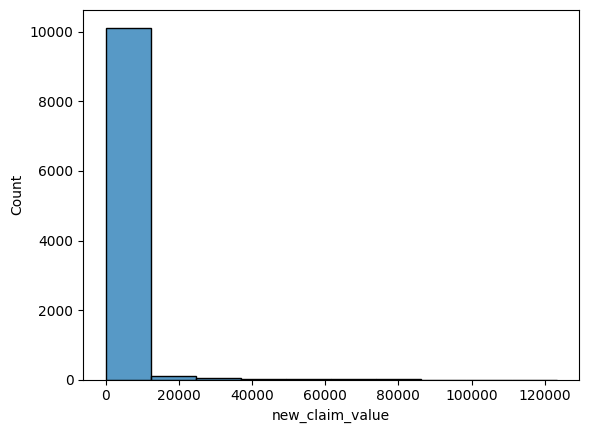

In [23]:
# Histogram for new_claim_value to see the distribution
sns.histplot(data_df['new_claim_value'], bins=10)

In [24]:
# The feature new_claim_value is severely right skewed. It's best to use non-linearly spaced bins to capture the more extreme values with few instances.
# Define bins
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]
# Define bin labels
labels = np.arange(1, 12)

# Apply the bins using pd.cut
data_df['claim_value_cat'] = pd.cut(data_df['new_claim_value'], bins = bins, labels= labels, include_lowest=True)

<Axes: ylabel='claim_value_cat'>

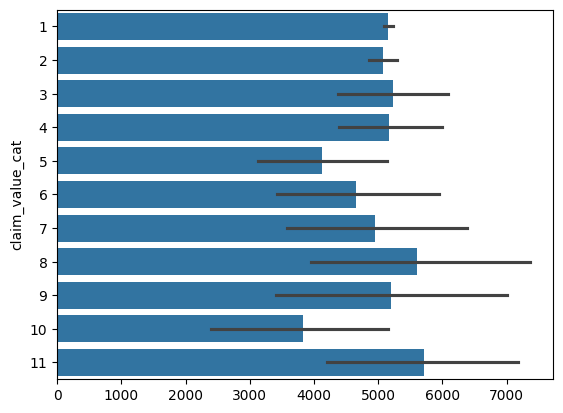

In [25]:
# We can now see the distribution of our new_claim_value categories by creating a barplot.
sns.barplot(data_df['claim_value_cat'])

In [26]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type,claim_value_cat
0,0,60.0,0,11.0,67349.0,No,0.0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban,1
1,0,43.0,0,11.0,91449.0,No,257252.0,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban,1
2,0,48.0,0,11.0,52881.0,No,0.0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban,1
3,0,35.0,1,10.0,16039.0,No,124191.0,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban,1
4,0,51.0,0,14.0,NaN,No,306251.0,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban,1


In [27]:
data_df['claim_value_cat'].value_counts(dropna=False)

claim_value_cat
1     9316
2      789
4       48
3       45
5       27
11      19
6       18
7       14
8       10
9        8
10       7
Name: count, dtype: int64

In [28]:
# Clean of copy training data
X = data_df.copy()
y = data_df['is_claim']

# Drop the targe feature from the X
X.drop(columns=['new_claim_value', 'is_claim'], inplace=True)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['claim_value_cat'])

In [29]:
# Check if the distribution of y_train and y_test class for is_claim:
train_ratio = round((y_train.sum()/len(y_train))*100,2)
test_ratio = round((y_test.sum()/len(y_test)*100),2)

print(f'Train positive class ratio: {train_ratio}%')
print(f'Test positive class ratio: {test_ratio}%')

Train positive class ratio: 26.48%
Test positive class ratio: 27.37%


In [30]:
X_train.drop(columns=['claim_value_cat'], inplace=True)
X_test.drop(columns=['claim_value_cat'], inplace=True)

In [31]:
X_train

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type
8452,0,57.0,0,NaN,33707.0,No,0.0,No,F,<High School,Blue Collar,40,Private,7200,10,SUV,no,0,0,No,1,1.0,Highly Rural/ Rural
7822,2,41.0,3,14.0,17321.0,No,109835.0,Yes,F,<High School,Blue Collar,24,Private,6530,4,Sports Car,no,0,0,No,3,1.0,Highly Urban/ Urban
1312,0,29.0,2,12.0,54310.0,Yes,174139.0,No,M,<High School,Clerical,39,Private,1500,4,Minivan,no,5419,1,No,5,6.0,Highly Urban/ Urban
921,0,46.0,1,13.0,62886.0,Yes,202178.0,No,F,Bachelors,Professional,18,Private,22260,1,Minivan,no,5290,1,No,6,6.0,Highly Urban/ Urban
8708,0,39.0,0,8.0,115182.0,No,312887.0,Yes,M,High School,Professional,25,Commercial,5400,1,Pickup,no,0,0,No,1,5.0,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5700,0,38.0,2,14.0,54064.0,No,201418.0,Yes,F,Bachelors,Professional,7,Private,12220,7,Sports Car,no,0,0,No,2,7.0,Highly Urban/ Urban
9650,0,38.0,0,10.0,22746.0,No,192479.0,Yes,F,Bachelors,Home Maker,5,Private,26300,6,Minivan,no,0,0,No,0,6.0,Highly Urban/ Urban
3204,0,48.0,0,15.0,38939.0,No,155006.0,No,M,Bachelors,Professional,28,Commercial,31970,4,Panel Truck,no,0,0,No,1,11.0,Highly Rural/ Rural
1427,0,29.0,2,13.0,26413.0,No,172043.0,Yes,F,High School,Clerical,29,Commercial,16200,4,Pickup,no,0,0,No,1,1.0,Highly Urban/ Urban


In [32]:
X_test

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type
5770,0,53.0,0,16.0,90526.0,No,262538.0,Yes,M,Bachelors,Professional,5,Commercial,30810,1,Panel Truck,no,0,0,No,0,NaN,Highly Rural/ Rural
8196,0,25.0,3,0.0,0.0,No,0.0,Yes,F,High School,Student,27,Commercial,5950,1,SUV,no,0,0,No,3,1.0,Highly Urban/ Urban
8626,0,51.0,0,9.0,44977.0,No,NaN,Yes,M,High School,Blue Collar,41,Commercial,6000,10,Pickup,yes,8060,2,No,6,1.0,Highly Urban/ Urban
6833,0,40.0,1,7.0,34512.0,Yes,0.0,No,M,High School,Blue Collar,51,Commercial,8950,6,Pickup,no,4955,1,No,7,1.0,Highly Urban/ Urban
9609,0,41.0,0,NaN,78834.0,No,200776.0,Yes,M,Masters,Manager,15,Commercial,29830,1,Panel Truck,yes,9980,1,No,4,17.0,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,0,46.0,0,NaN,57136.0,No,192619.0,Yes,M,High School,Professional,55,Commercial,11810,8,Pickup,yes,8446,1,No,7,8.0,Highly Urban/ Urban
4277,0,29.0,1,0.0,0.0,No,66346.0,Yes,F,<High School,Home Maker,34,Private,6170,1,SUV,no,0,0,No,0,1.0,Highly Rural/ Rural
4222,2,38.0,3,15.0,NaN,No,339360.0,Yes,F,Bachelors,Blue Collar,15,Commercial,38260,1,Van,no,0,0,No,2,11.0,Highly Urban/ Urban
1737,0,48.0,0,9.0,201768.0,No,0.0,No,F,Masters,Manager,37,Private,31780,7,Minivan,no,0,0,No,0,19.0,Highly Urban/ Urban


In [33]:
# Exploratory Data Analysis
# Join X_train and y_train to investigate correlation
eda_test_data = X_train.copy()
eda_test_data['is_claim'] = y_train

In [34]:
# Binary encoding the two-value features ['single_parent', 'married', 'gender', 'red_vehicle', 'licence_revoked']
binary_cols = ['single_parent', 'married', 'gender', 'red_vehicle', 'licence_revoked']

# Define map values
mapping = {'Yes': 1,
           'No': 0,
           'yes': 1,
           'no': 0,
           'M': 1,
           'F': 0
          }

# Binary encode the given function:
def binary_encode(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

# Calling the binary_encode function:
eda_test_data = binary_encode(eda_test_data, binary_cols, mapping)

In [35]:
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707.0,0,0.0,0,0,<High School,Blue Collar,40,Private,7200,10,SUV,0,0,0,0,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321.0,0,109835.0,1,0,<High School,Blue Collar,24,Private,6530,4,Sports Car,0,0,0,0,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310.0,1,174139.0,0,1,<High School,Clerical,39,Private,1500,4,Minivan,0,5419,1,0,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886.0,1,202178.0,0,0,Bachelors,Professional,18,Private,22260,1,Minivan,0,5290,1,0,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182.0,0,312887.0,1,1,High School,Professional,25,Commercial,5400,1,Pickup,0,0,0,0,1,5.0,Highly Urban/ Urban,0


In [36]:
eda_test_data['type_of_use'].value_counts(dropna=False)

type_of_use
Private       5208
Commercial    3032
Name: count, dtype: int64

In [37]:
eda_test_data.corr(numeric_only=True).sort_values(by='is_claim', ascending=False)

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,commute_dist,vehicle_value,policy_tenure,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,is_claim
is_claim,0.109085,-0.107146,0.128697,-0.053815,-0.147085,0.154323,-0.193881,-0.132326,-0.021205,0.044019,-0.103979,-0.082839,-0.007045,0.147094,0.224952,0.158972,0.218605,-0.113344,1.000000
5_year_num_of_claims,0.034724,-0.037820,0.038404,-0.026019,-0.044323,0.060335,-0.092703,-0.070880,0.014060,0.006396,-0.034264,-0.015396,0.027464,0.491048,1.000000,0.054301,0.403083,-0.023960,0.224952
license_points,0.052874,-0.079780,0.071365,-0.040719,-0.065223,0.074748,-0.097057,-0.050486,-0.006218,0.006975,-0.053148,-0.032602,0.004845,0.267866,0.403083,0.054818,1.000000,-0.035502,0.218605
licence_revoked,0.040039,-0.045184,0.051109,-0.009085,-0.031050,0.052374,-0.048395,-0.039376,-0.024676,0.002763,-0.028597,-0.029388,-0.018617,0.422329,0.054301,1.000000,0.054818,-0.027414,0.158972
single_parent,0.204141,-0.314111,0.456293,-0.027043,-0.069598,1.000000,-0.248240,-0.476495,-0.061451,-0.016323,-0.042579,0.009828,-0.039510,0.044080,0.060335,0.052374,0.074748,-0.063892,0.154323
5_year_total_claims_value,0.035981,-0.040818,0.049397,-0.005708,-0.049042,0.044080,-0.067330,-0.043098,-0.009735,-0.017241,-0.030692,-0.012395,0.006578,1.000000,0.491048,0.422329,0.267866,-0.031716,0.147094
num_of_children,0.461488,-0.448207,1.000000,0.079570,-0.158150,0.456293,-0.106974,0.037708,-0.114426,-0.000621,-0.109210,0.012882,-0.072370,0.049397,0.038404,0.051109,0.071365,-0.152561,0.128697
num_young_drivers,1.000000,-0.076813,0.461488,0.038082,-0.046508,0.204141,-0.022470,0.037441,-0.041781,0.012918,-0.026245,-0.004106,-0.045062,0.035981,0.034724,0.040039,0.052874,-0.062621,0.109085
commute_dist,0.012918,0.003201,-0.000621,-0.008878,-0.051479,-0.016323,-0.031111,0.007881,-0.007181,1.000000,-0.024179,-0.002833,0.015903,-0.017241,0.006396,0.002763,0.006975,-0.037156,0.044019
red_vehicle,-0.045062,0.028833,-0.072370,0.054180,0.061301,-0.039510,0.027262,-0.018030,0.664545,0.015903,0.028362,-0.010116,1.000000,0.006578,0.027464,-0.018617,0.004845,0.012896,-0.007045


<Axes: >

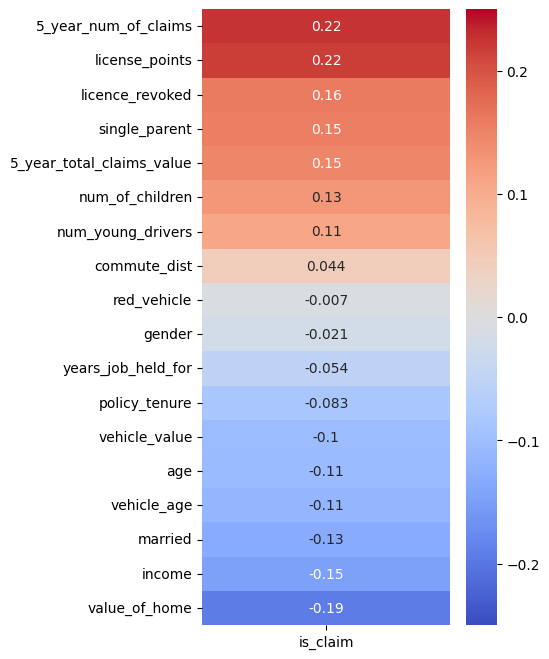

In [38]:
fig, ax = plt.subplots(figsize = (4,8))

corr_matrix = eda_test_data.corr(numeric_only=True).sort_values(by='is_claim', ascending=False)
corr_matrix_no_claim = corr_matrix.drop('is_claim')

sns.heatmap(corr_matrix_no_claim[['is_claim']], cmap='coolwarm', annot=True, vmax=0.25, vmin=-0.25)

Obervations:

Note, we are not assuming causation, only speculating at possible reasons for correlation.

* Some of the features show much stronger positive correlation than others - these are perhaps the most expected, including:
    * 5_year_num_of_claims: Having made claims previously would suggest they are more likely to make claims in the future
    * license_points: Having points on your license may suggest your driving quality is poor, and make you more likely to be involved in an accident
    * license_revoked: Having your license revoked suggests several minor or a serious driving related offense, perhaps reflecting your driving quality
* Stronger negative correlations:
    * Home value
* Features with negligable correlation:
    * Commute distance, red vehicle and gender show very weak correlations, so it may be beneficial to remove these to reduce the number of features passed to the models.

In [39]:
# Data Cleaning and Preprocessing
# Dropping the 'red_vehicle' feature as it shows little to no correlation with the target variable 'is_claim'.
X_train_raw = X_train.copy()

cols_to_drop = [
    'red_vehicle',
]

X_train_raw.drop(columns=cols_to_drop, axis=1, inplace=True)

In [40]:
# Handling missing values
# Check the number of missing values
X_train_raw.isnull().sum()

num_young_drivers              0
age                            5
num_of_children                0
years_job_held_for           433
income                       474
single_parent                  0
value_of_home                462
married                        0
gender                         0
highest_education              0
occupation                   527
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
vehicle_age                  517
address_type                   0
dtype: int64

In [41]:
X_train_raw.isnull().sum().sum()

np.int64(2418)

In [42]:
# Using KNNImputer to Impute the missing values.
knn_imputer = KNNImputer(n_neighbors=2)

# Defining the numerical columns
numerical_cols_df = X_train_raw.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

In [43]:
numerical_cols_df

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
8452,0,57.0,0,NaN,33707.0,0.0,40,7200,10,0,0,1,1.0
7822,2,41.0,3,14.0,17321.0,109835.0,24,6530,4,0,0,3,1.0
1312,0,29.0,2,12.0,54310.0,174139.0,39,1500,4,5419,1,5,6.0
921,0,46.0,1,13.0,62886.0,202178.0,18,22260,1,5290,1,6,6.0
8708,0,39.0,0,8.0,115182.0,312887.0,25,5400,1,0,0,1,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5700,0,38.0,2,14.0,54064.0,201418.0,7,12220,7,0,0,2,7.0
9650,0,38.0,0,10.0,22746.0,192479.0,5,26300,6,0,0,0,6.0
3204,0,48.0,0,15.0,38939.0,155006.0,28,31970,4,0,0,1,11.0
1427,0,29.0,2,13.0,26413.0,172043.0,29,16200,4,0,0,1,1.0


In [44]:
numerical_cols

['num_young_drivers',
 'age',
 'num_of_children',
 'years_job_held_for',
 'income',
 'value_of_home',
 'commute_dist',
 'vehicle_value',
 'policy_tenure',
 '5_year_total_claims_value',
 '5_year_num_of_claims',
 'license_points',
 'vehicle_age']

In [45]:
# Defining the categorical columns
cat_cols_df = X_train_raw.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

In [46]:
cat_cols_df.head(2)

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
8452,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
7822,No,Yes,F,<High School,Blue Collar,Private,Sports Car,No,Highly Urban/ Urban


In [47]:
cat_cols

['single_parent',
 'married',
 'gender',
 'highest_education',
 'occupation',
 'type_of_use',
 'vehicle_type',
 'licence_revoked',
 'address_type']

In [48]:
# Define a function to impute the numerical features using KNNImputer
def num_knn_impute(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Running the function to impute the numerical values using KNN
num_test_data_imputed = num_knn_impute(X_train_raw, numerical_cols, knn_imputer)

In [49]:
num_test_data_imputed.isna().sum().sum()

np.int64(0)

In [50]:
# Checking some of the instances that still have missing values.
num_cols_df = X_train_raw[numerical_cols].reset_index(drop=True)

# Selecting the rows with missing values and print them out.
missing_data_df = num_cols_df[num_cols_df.isna().any(axis=1)]
missing_data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0,57.0,0,NaN,33707.0,0.0,40,7200,10,0,0,1,1.0
11,0,36.0,2,13.0,19934.0,NaN,17,10790,6,7797,2,9,1.0
19,0,59.0,0,11.0,123969.0,347418.0,35,31540,1,0,0,1,NaN
25,0,51.0,0,7.0,141546.0,351285.0,18,29330,4,1184,2,4,NaN
28,1,51.0,1,8.0,NaN,253662.0,5,12430,1,9000,1,0,11.0


In [51]:
# missing_data_df is created just to compare it with the num_test_data_imputed to check if the data are properly imputed
samples = missing_data_df.index.to_list()
num_test_data_imputed.loc[samples].head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0
11,0.0,36.0,2.0,13.0,19934.0,158778.5,17.0,10790.0,6.0,7797.0,2.0,9.0,1.0
19,0.0,59.0,0.0,11.0,123969.0,347418.0,35.0,31540.0,1.0,0.0,0.0,1.0,8.5
25,0.0,51.0,0.0,7.0,141546.0,351285.0,18.0,29330.0,4.0,1184.0,2.0,4.0,7.0
28,1.0,51.0,1.0,8.0,67333.0,253662.0,5.0,12430.0,1.0,9000.0,1.0,0.0,11.0


In [52]:
# confirmed, missing values are imputed
# Use Imputer again for categorical features using mode (most_frequent)
simple_imputer = SimpleImputer(strategy='most_frequent')

# Defining function to impute cat features using simple imputer
def cat_simple_imputer(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Calling the function to impute missing categorical values
cat_test_data_imputed = cat_simple_imputer(X_train_raw, cat_cols, simple_imputer)

In [53]:
# Checking if the missing values are imputed
cat_cols_df = X_train_raw[cat_cols].reset_index(drop=True)

# Selecting rows with missing values
missing_cat_data_df = cat_cols_df[num_cols_df.isna().any(axis=1)]

# Previewing the instances with missing values
missing_cat_data_df.head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
11,Yes,No,M,High School,Clerical,Private,Pickup,No,Highly Urban/ Urban
19,No,Yes,M,Masters,NaN,Commercial,Panel Truck,No,Highly Urban/ Urban
25,No,No,M,PhD,Manager,Commercial,Panel Truck,No,Highly Urban/ Urban
28,No,Yes,M,High School,Blue Collar,Commercial,Minivan,No,Highly Urban/ Urban


In [54]:
# Show the same instances and see if missing values are imputed
samples = missing_cat_data_df.index.to_list()
cat_test_data_imputed.loc[samples].head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
11,Yes,No,M,High School,Clerical,Private,Pickup,No,Highly Urban/ Urban
19,No,Yes,M,Masters,Blue Collar,Commercial,Panel Truck,No,Highly Urban/ Urban
25,No,No,M,PhD,Manager,Commercial,Panel Truck,No,Highly Urban/ Urban
28,No,Yes,M,High School,Blue Collar,Commercial,Minivan,No,Highly Urban/ Urban


In [55]:
# Joining the imputed numerical and categorical dataframes to complete the whole traning dataset
train_imputed_df = pd.concat([num_test_data_imputed, cat_test_data_imputed], axis=1)

# Preview
train_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,No,Yes,F,<High School,Blue Collar,Private,Sports Car,No,Highly Urban/ Urban
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,Yes,No,M,<High School,Clerical,Private,Minivan,No,Highly Urban/ Urban
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,Yes,No,F,Bachelors,Professional,Private,Minivan,No,Highly Urban/ Urban
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,No,Yes,M,High School,Professional,Commercial,Pickup,No,Highly Urban/ Urban


In [56]:
# See if there are still missing values
train_imputed_df.isnull().sum()

num_young_drivers            0
age                          0
num_of_children              0
years_job_held_for           0
income                       0
value_of_home                0
commute_dist                 0
vehicle_value                0
policy_tenure                0
5_year_total_claims_value    0
5_year_num_of_claims         0
license_points               0
vehicle_age                  0
single_parent                0
married                      0
gender                       0
highest_education            0
occupation                   0
type_of_use                  0
vehicle_type                 0
licence_revoked              0
address_type                 0
dtype: int64

In [57]:
# Categorical Feature Encoding
cat_test_data_imputed.nunique()

single_parent        2
married              2
gender               2
highest_education    5
occupation           8
type_of_use          2
vehicle_type         6
licence_revoked      2
address_type         2
dtype: int64

In [58]:
# single_parent, married, gender, type_of_use, licence_revoked, address_type have only two distinct values, hence they can be binary encoded.
# highest_education has 5 order values, hence ordinal encoding can be applied
# occupation, vehicle_type have multiple distinct values (not ordinal), hence one-hot encoding will be applied.

# Defining ordinal features
cat_cols_ordinal = ['highest_education']

# Defining binary features
cat_cols_binary = ['single_parent', 'married', 'gender', 'type_of_use', 'licence_revoked', 'address_type']

# Defining one-hot encoding features
cat_cols_one_hot_encode = ['occupation', 'vehicle_type']

In [59]:
cat_test_data_imputed['highest_education'].value_counts(dropna=False)

highest_education
High School     2381
Bachelors       2247
Masters         1667
<High School    1201
PhD              744
Name: count, dtype: int64

In [60]:
# Ranking the order of 'highest_education' for ordinal encoding.
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

In [61]:
# Defining ordinal order
ordinal_encoder = OrdinalEncoder(categories=education_rank)

# Defining binary encoder
binary_encoder = OrdinalEncoder()

#Defining one-hot encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [62]:
# Encoding the values using .fit_transform to the features to be encoded.

# Ordinal encoding
ordinal_encoded = ordinal_encoder.fit_transform(cat_test_data_imputed[cat_cols_ordinal])

# Binary encoding
binary_encoded = binary_encoder.fit_transform(cat_test_data_imputed[cat_cols_binary])

# One-hot encoding
one_hot_encoded = one_hot_encoder.fit_transform(cat_test_data_imputed[cat_cols_one_hot_encode])

In [63]:
# Creating dataframes each array
ordinal_encoded_df = pd.DataFrame(ordinal_encoded)
ordinal_encoded_df.columns = cat_cols_ordinal

binary_encoded_df = pd.DataFrame(binary_encoded)
binary_encoded_df.columns = cat_cols_binary

one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = one_hot_encoder.get_feature_names_out()

In [64]:
# Joining encoded dfs to a single df and show head
all_cat_encoded_df = pd.concat([ordinal_encoded_df, binary_encoded_df, one_hot_encoded_df], axis=1)
all_cat_encoded_df.head()

,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [65]:
# Joining imputed numerical and categorical data
X_train_cleaned = pd.concat([train_imputed_df[numerical_cols], all_cat_encoded_df], axis=1)

In [66]:
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Since we've used one-hot encoding for some of the features, we will almost certainly have issues with the 'dummy variable trap'. This occurs when one of the dummy variables is redudant, and introduces perfect multicollinearity. In simple terms, knowing the values of all feature values - 1 allows you to perfectly predict the last one. We can check the presence of multicolinearity using the variance inflation factor, or VIF:

In [67]:
# Function to calculate VIF
def calculate_vif(dataframe):
    # Add a constant to the DataFrame (intercept term)
    df_with_constant = add_constant(dataframe)

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_with_constant.columns
    vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                       for i in range(df_with_constant.shape[1])]

    return vif_data

# Calculate VIF for encoded data
vif_df = calculate_vif(X_train_cleaned)
vif_df

C:\Users\Jerome\Desktop\Machine Learning Projects\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Jerome\Desktop\Machine Learning Projects\venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,const,0.000000
1,num_young_drivers,1.317458
2,age,1.470704
3,num_of_children,2.083100
4,years_job_held_for,1.437881
5,income,2.633292
6,value_of_home,2.120414
7,commute_dist,1.039162
8,vehicle_value,2.030342
9,policy_tenure,1.005861


We can clearly see the features that were one-hot encoded (occupation and vehicle type) show perfect multicolinearity. The easiest way to deal with this is to drop one of the dummy variables from the encoded data. This is often referred to as dropping the 'reference category' or 'baseline' category.

In [68]:
X_train_cleaned = X_train_cleaned.drop(['occupation_Blue Collar' ,'vehicle_type_Minivan'], axis=1)

In [69]:
# We can now check VIF values again
# Calculate VIF for encoded data
vif_df = calculate_vif(X_train_cleaned)
vif_df

,Feature,VIF
0,const,80.124998
1,num_young_drivers,1.317458
2,age,1.470704
3,num_of_children,2.083100
4,years_job_held_for,1.437881
5,income,2.633292
6,value_of_home,2.120414
7,commute_dist,1.039162
8,vehicle_value,2.030342
9,policy_tenure,1.005861


In [70]:
# Model Selectionabs
# Start by using several of the most popular classifiers with default parameters and compare how well they perform to indentify which might be best to proceed with.

# Define the classifiers to test
clfs = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=2000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Linear SVM', LinearSVC(random_state=42, max_iter=1000, dual='auto')),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('Gradient Boost', GradientBoostingClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
]

In [71]:
# uUsing cross-validation to get a better understanding of each models performance, rather than just a single test. Let's create a KFold object so we can use the same folds for each classifier.

# Create KFold object with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
results = {}

# Evaluate each classifier using cross-validation
for clf_name, clf in clfs:
    cv_scores = cross_val_score(clf, X_train_cleaned, y_train, cv=kf)
    results[clf_name] = cv_scores

cv_scores_df = pd.DataFrame(results)

Text(0.5, 1.0, 'Cross-Validation Scores for Different Classifiers')

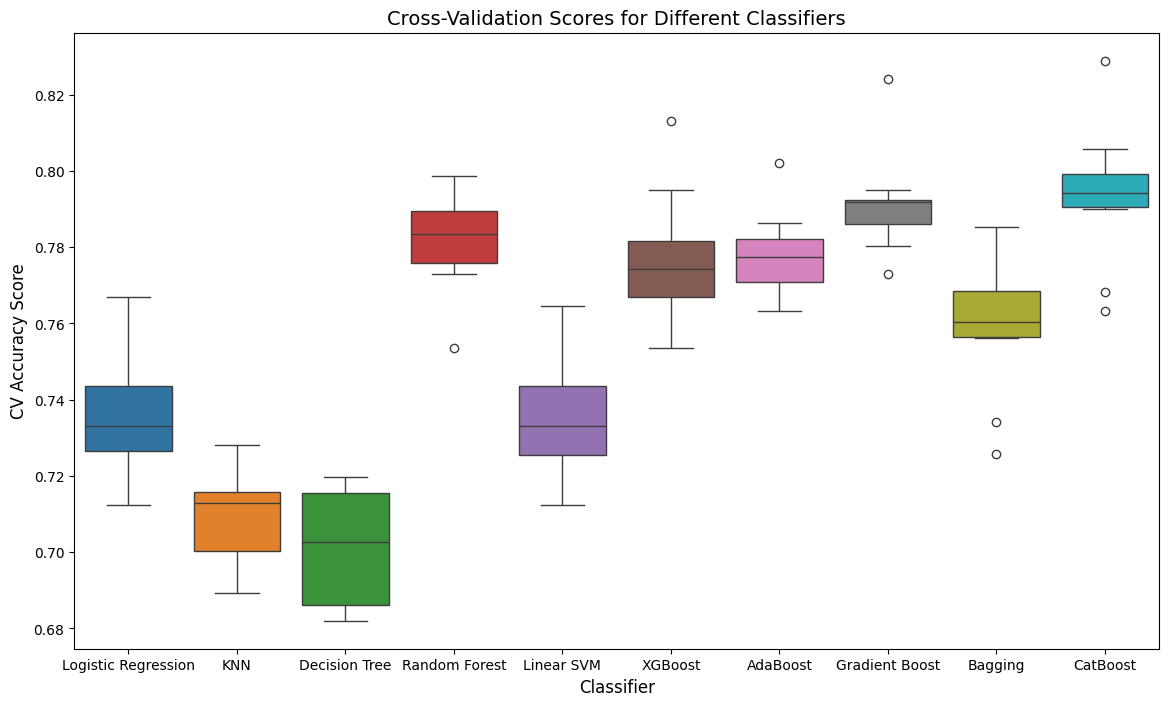

In [72]:
# Plotting the results of each test, for each classifyer with a boxplot so we can compare the models.
# Plot scores
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(cv_scores_df)

# Add axis labels
ax.set_xlabel('Classifier', fontsize=12)
ax.set_ylabel('CV Accuracy Score', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Classifiers', fontsize=14)

From the table, we can see the best performing model was CatBoost, followed by Gradient Boost. The worst performing model was the Descision Tree.

Although the CatBoost and Gradient Boost models performed better, I'll proceed for now with the XGBoost model, as hyperparameter tuning is much faster.

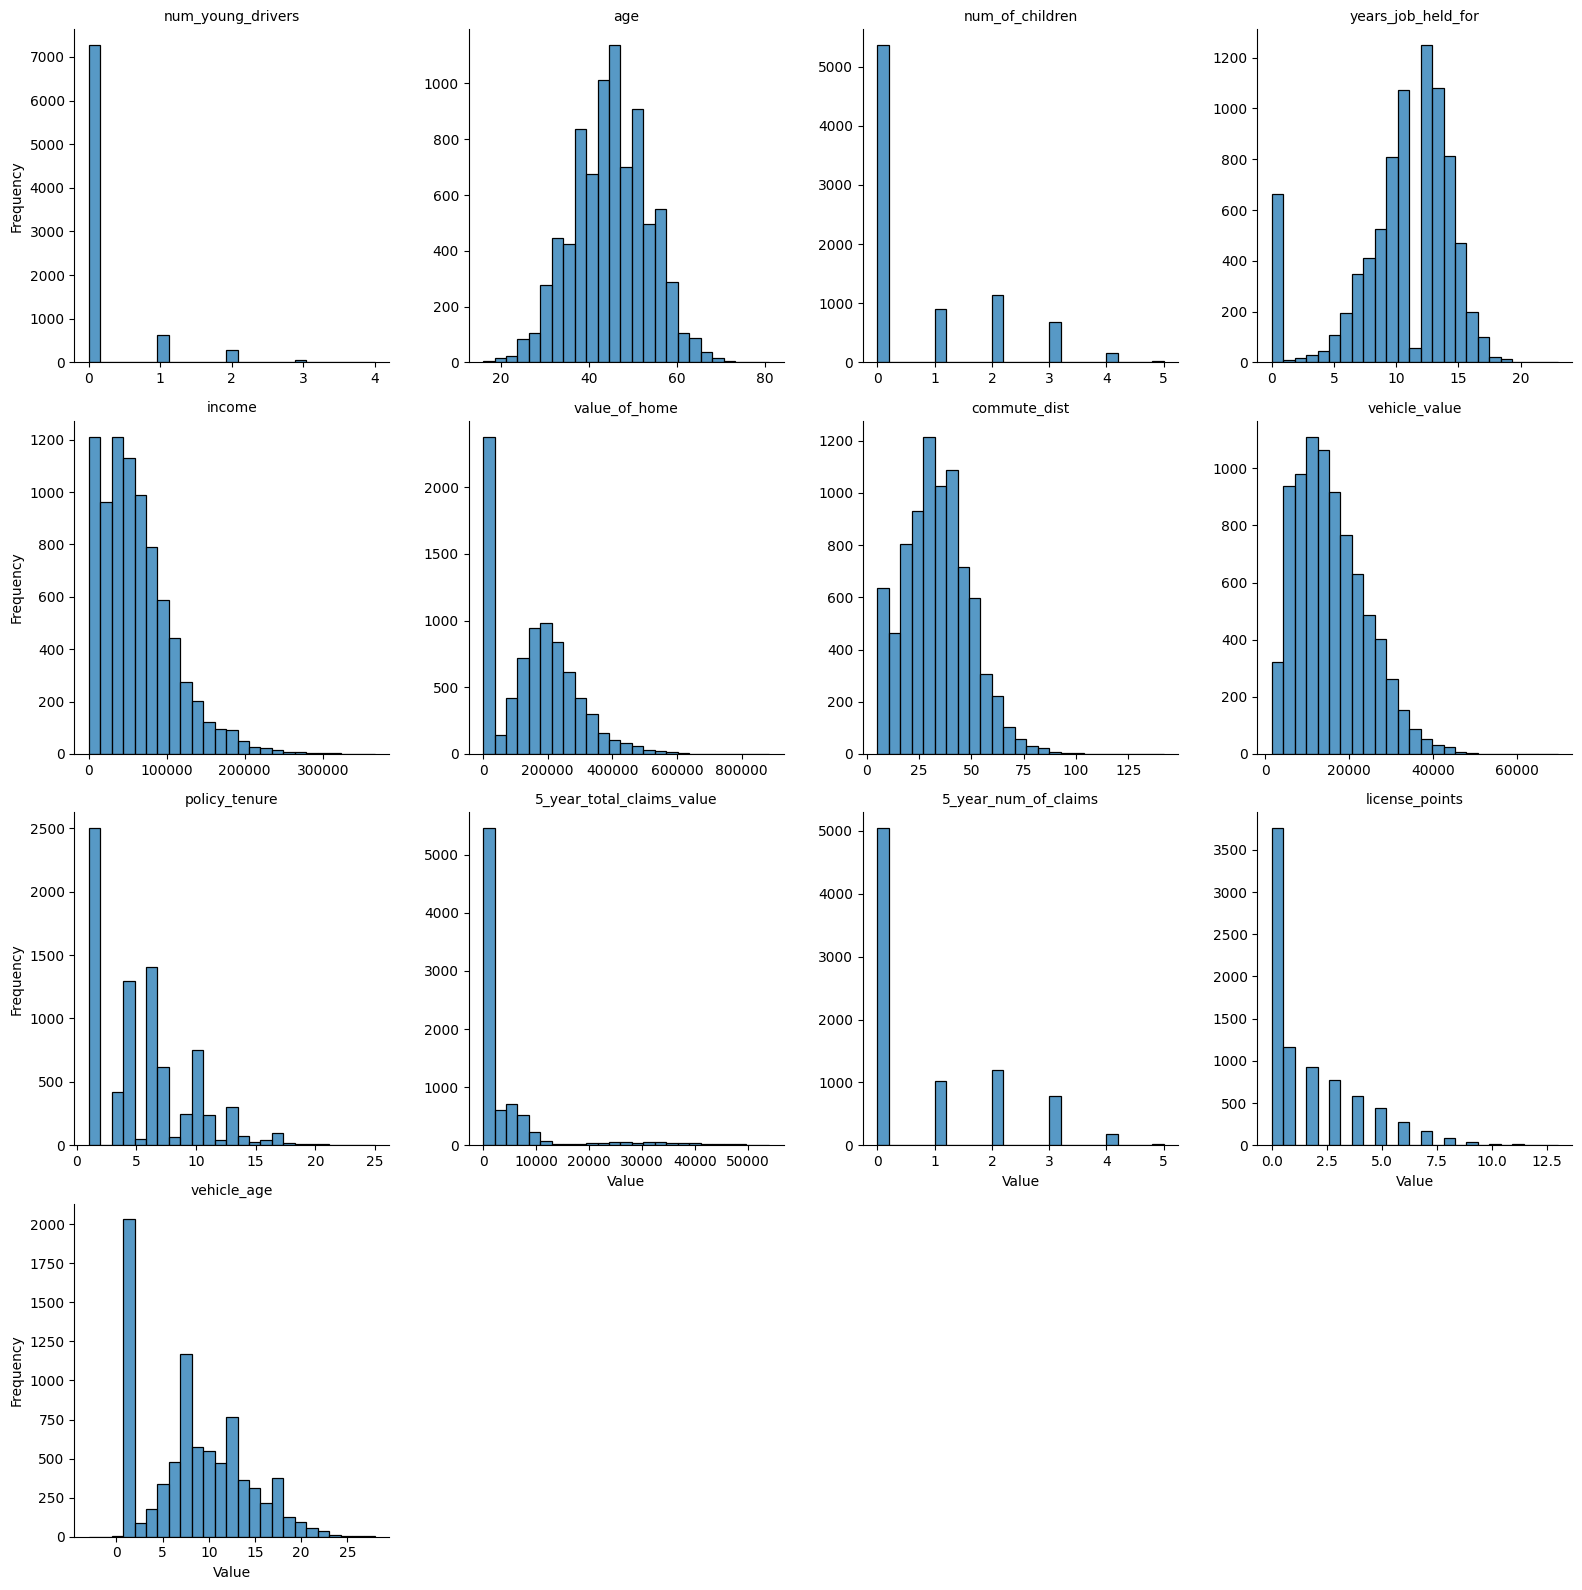

In [73]:
# Feature Engineering

# Melting the DataFrame to long format
melted_X_train = X_train_cleaned[numerical_cols].melt(var_name='Column', value_name='Value')

# Creating a FacetGrid
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)

# Mapping the sns.histplot to each facet
g.map(sns.histplot, 'Value', bins=25)

# Adding titles and labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')

plt.tight_layout
plt.show()

In [74]:
# We can see that some of the features have a right skew. We can try to log transform these features to reduce the skew.

# Defining the right-skewed features
skewed_features = ['income', 'value_of_home', 'commute_dist', 'vehicle_value', 'policy_tenure', 'license_points']

# Getting the square root transform the right-skewed features
def sqrt_of_features(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.sqrt(data[feature])
    return data

# Applying the function to X_train
X_train_cleaned_sqrt = sqrt_of_features(X_train_cleaned, skewed_features)

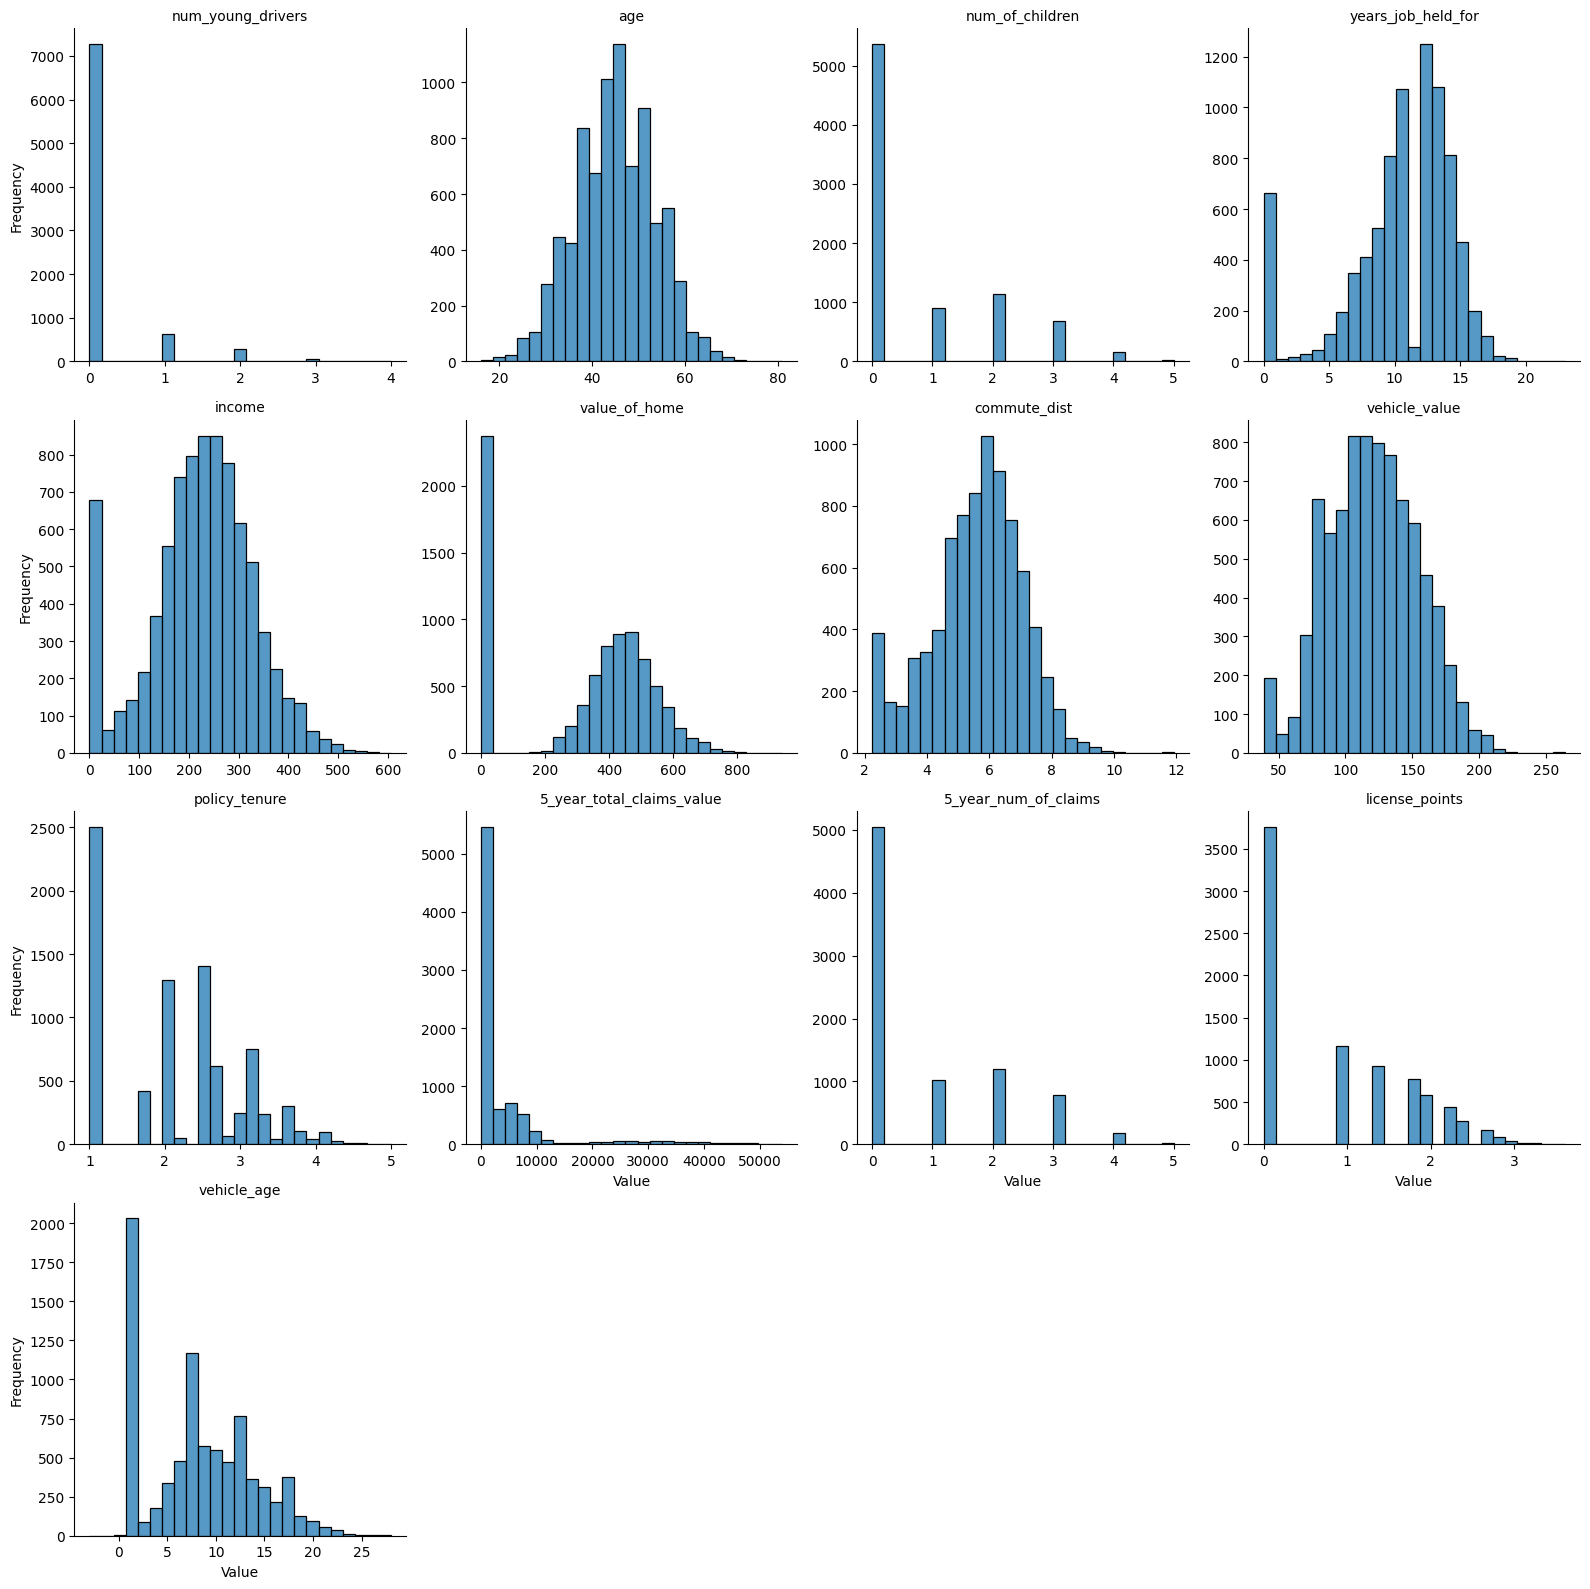

In [75]:
# looking at the distributions again to see if the log transform was effective at reducing the right skews.
melted_X_train = X_train_cleaned_sqrt[numerical_cols].melt(var_name='Column', value_name='Value')
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.histplot, 'Value', bins=25)
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')
plt.tight_layout()
plt.show()

In [76]:
# The skews have been reduced, so let's now see if it has improved the performance of the XGBoost model.

xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf)
cv_scores_sqrt = cross_val_score(xgb_boost_clf, X_train_cleaned_sqrt, y_train, cv=kf)

print(f'CV score without sqrt transform: {cv_scores.mean()}')
print(f'CV score with sqrt transform: {cv_scores_sqrt.mean()}')

CV score without sqrt transform: 0.7770631067961167
CV score with sqrt transform: 0.7770631067961167


It's clear that our sqrt transform made no impact in improving the base score. This is often to be expected with boosting models, as they are less sensitive to skew and scale than some models. However, it may be beneficial to our regression model later so we'll keep it.

In [77]:
# Feature Scaling

# Define function to scale numeric features
def scale_features(data_df, numeric_features):
    data = data_df.copy()
    # Initialise scaler
    scaler = StandardScaler()
    # Fit scaler to training data
    scaler.fit(data[numeric_features])
    # Transform numeric features
    data[numeric_features] = scaler.transform(data[numeric_features])
    return data

# Apply the function to X_train
X_train_cleaned_scaled = scale_features(X_train_cleaned_sqrt, numerical_cols)

In [78]:
xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf)
cv_scores_scaled = cross_val_score(xgb_boost_clf, X_train_cleaned_scaled, y_train, cv=kf)

print(f'CV score without sqrt transform: {cv_scores.mean()}')
print(f'CV score with sqrt transform: {cv_scores_scaled.mean()}')

CV score without sqrt transform: 0.7770631067961167
CV score with sqrt transform: 0.7770631067961167


Again, it's clear that the scaling made no impact in improving the base score. However, it may be beneficial to our regression model later so we'll keep it.

In [79]:
X_train_cleaned = X_train_cleaned_scaled.copy()

Model Pipeline

Custom Transformers
As we want to drop the unwanted 'red_vehicle' column, we'll create a custom transformer to do this that we can use in our pipeline.

In [80]:
# Custom transformer to drop specified columns
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)
    
    def get_feature_names_out(self, input_features=None):
        return None

In [81]:
class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.columns_to_transform] = np.sqrt(X[self.columns_to_transform])
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features

7.2. Pipelines
Defining the pipelines for each of data/encoding types.

In [82]:
from sklearn import set_config

# Setting transformer output to df so it can be referenced as columns names
set_config(transform_output='pandas')

In [85]:
# Define column dropper pipeline
cols_to_drop_pipeline = Pipeline([
    ('col_dropper', ColumnDropper(cols_to_drop))
])

skewed_features = ['income', 'value_of_home', 'commute_dist', 'vehicle_value', 'policy_tenure', 'license_points']

# Define numerical feature pipeline
num_pipeline = Pipeline([
    ('knn_imputer', KNNImputer(n_neighbors=2)),
    ('sqrt', SqrtTransformer(skewed_features)),
    ('scaler', StandardScaler()),
])

# Define rank of education levels
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal categorical feature pipeline (highest_education feature)
cat_ord_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder(categories=education_rank)),
])

# Define binary categorical feature pipeline
cat_bin_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('binary_encoder', OrdinalEncoder()),
])

# Define one-hot categorical feature pipeline
cat_one_hot_pipeline = Pipeline([
    ('cat_simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')),
])

# Define preprocessing pipeline with a column transformer
preprocess_pipeline = ColumnTransformer([
    ('drop_features', cols_to_drop_pipeline, cols_to_drop),
    ('num', num_pipeline, numerical_cols),
    ('cat_ord', cat_ord_pipeline, cat_cols_ordinal),
    ('cat_bin', cat_bin_pipeline, cat_cols_binary),
    ('cat_one_hot', cat_one_hot_pipeline, cat_cols_one_hot_encode),
])

Now, the X_train dataset is ready to be transformed with the pipel
ine.

In [86]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

The test data are transformed using the pipeline. It can be checked that the pipeline is correct by checking it against the DataFrame built manually. Just need to make sure the column names match so we can compare them.

In [90]:
# Create df from processed data
X_train_prepared_df = pd.DataFrame(
    X_train_prepared,
    columns=preprocess_pipeline.get_feature_names_out(),
)

# Get names of new one-hot columns
one_hot_col_names = list(preprocess_pipeline.transformers_[4][1][1].get_feature_names_out(cat_cols_one_hot_encode))

# Create list of all columns names
new_col_names = numerical_cols + cat_cols_ordinal + cat_cols_binary + one_hot_col_names

# Rename df columns
X_train_prepared_df.columns = new_col_names

# Reset index
X_train_prepared_df.reset_index(drop=True, inplace=True)

# Inspect df
X_train_prepared_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.332668,1.409817,-0.643344,-2.563674,-0.375723,-1.452458,0.498062,-1.040804,1.139483,-0.461230,-0.691403,0.092242,-1.295667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3.669060,-0.453096,2.054902,0.874127,-0.866152,0.037836,-0.479232,-1.159364,-0.142286,-0.461230,-0.691403,0.878344,-1.295667,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.332668,-1.850281,1.155487,0.383013,0.090791,0.424047,0.443522,-2.392885,-0.142286,0.161972,0.177994,1.419574,-0.405338,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.332668,0.129064,0.256071,0.628570,0.258015,0.569484,-0.929180,0.845452,-1.245093,0.147137,0.177994,1.648754,-0.405338,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.332668,-0.685960,-0.643344,-0.599216,1.093996,1.062875,-0.409978,-1.374057,-1.245093,-0.461230,-0.691403,0.092242,-0.583403,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [91]:
# Inspect manually created df
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.332668,1.409817,-0.643344,-2.563674,-0.375723,-1.452458,0.498062,-1.040804,1.139483,-0.461230,-0.691403,0.092242,-1.295667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3.669060,-0.453096,2.054902,0.874127,-0.866152,0.037836,-0.479232,-1.159364,-0.142286,-0.461230,-0.691403,0.878344,-1.295667,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.332668,-1.850281,1.155487,0.383013,0.090791,0.424047,0.443522,-2.392885,-0.142286,0.161972,0.177994,1.419574,-0.405338,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.332668,0.129064,0.256071,0.628570,0.258015,0.569484,-0.929180,0.845452,-1.245093,0.147137,0.177994,1.648754,-0.405338,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.332668,-0.685960,-0.643344,-0.599216,1.093996,1.062875,-0.409978,-1.374057,-1.245093,-0.461230,-0.691403,0.092242,-0.583403,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [92]:
X_train_cleaned.equals(X_train_prepared_df)

True

Great! It can be seen that the output from the pipeline is the same as the manually created DataFrame.